In [1]:
# Imports & Config

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

np.random.seed(42)

K     = 10      # number of arms
STEPS = 1000    # timesteps per run
RUNS  = 2000    # independent runs to average over

In [2]:

# Bandit & Core Logic 


def new_bandit():
    """Return true action values q*(a) ~ N(0,1) for a fresh bandit."""
    return np.random.randn(K)

def pull(q_star, action):
    """Reward ~ N(q*(action), 1)."""
    return q_star[action] + np.random.randn()

def run_bandit(epsilon=0.0, init_value=0.0, ucb_c=None):
    """
    Run one full experiment (RUNS x STEPS).
    Returns avg_reward [STEPS] and pct_optimal [STEPS].
    """
    all_rewards  = np.zeros((RUNS, STEPS))
    all_optimal  = np.zeros((RUNS, STEPS))

    for r in range(RUNS):
        q_star  = new_bandit()
        optimal = np.argmax(q_star)

        Q = np.full(K, init_value, dtype=float)   # value estimates
        N = np.zeros(K, dtype=int)                 # action counts

        for t in range(1, STEPS + 1):
            # ── action selection ──────────────────────────────────────────
            if ucb_c is not None:
                # UCB: untried arms → +inf, else Q + c*sqrt(ln t / N)
                with np.errstate(divide='ignore', invalid='ignore'):
                    bonus = np.where(N == 0, np.inf,
                                     ucb_c * np.sqrt(np.log(t) / N))
                action = np.argmax(Q + bonus)
            elif epsilon > 0 and np.random.rand() < epsilon:
                action = np.random.randint(K)      # explore
            else:
                action = np.argmax(Q)              # exploit

            # ── observe reward ────────────────────────────────────────────
            reward = pull(q_star, action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]   # incremental mean

            all_rewards[r, t-1] = reward
            all_optimal[r, t-1] = (action == optimal)

    return all_rewards.mean(axis=0), all_optimal.mean(axis=0) * 100


In [3]:

# All Strategies

print("Running experiments … (takes ~30–60 s)")

strategies = {
    "ε=0  (greedy)":       dict(epsilon=0.0),
    "ε=0.01":              dict(epsilon=0.01),
    "ε=0.1":               dict(epsilon=0.1),
    "Optimistic Q₁=5, ε=0": dict(epsilon=0.0, init_value=5.0),
    "UCB  c=2":            dict(ucb_c=2.0),
}

results = {}
for name, kwargs in strategies.items():
    print(f"  {name} ...", end=" ", flush=True)
    avg_r, pct_opt = run_bandit(**kwargs)
    results[name] = (avg_r, pct_opt)
    print(f"final avg reward = {avg_r[-1]:.3f}")

print("Done.")

Running experiments … (takes ~30–60 s)
  ε=0  (greedy) ... final avg reward = 1.012
  ε=0.01 ... final avg reward = 1.310
  ε=0.1 ... final avg reward = 1.316
  Optimistic Q₁=5, ε=0 ... final avg reward = 1.447
  UCB  c=2 ... final avg reward = 1.480
Done.


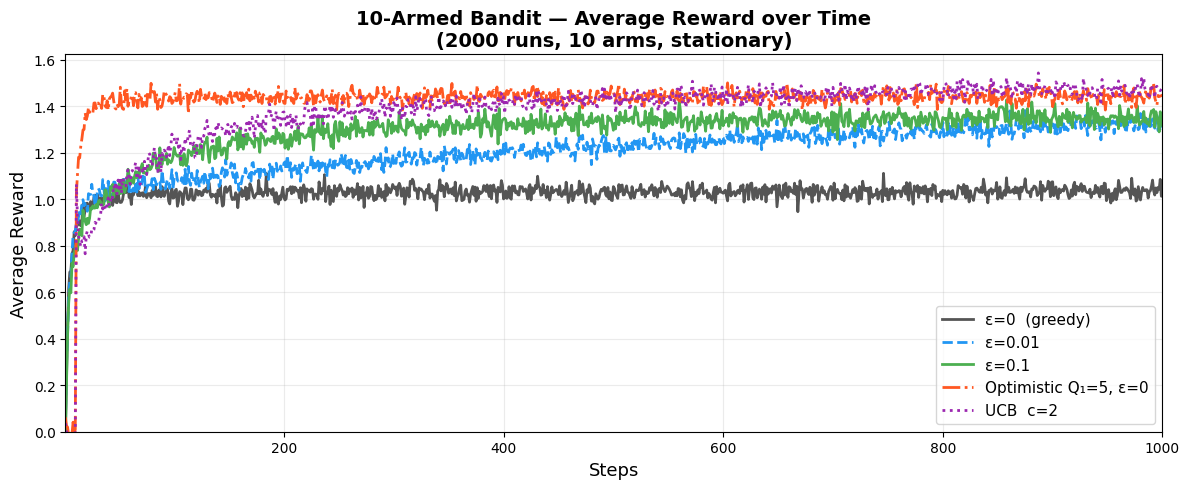

In [4]:

# Average Reward over Time


colors  = ["#555555", "#2196F3", "#4CAF50", "#FF5722", "#9C27B0"]
ls_list = ["-",       "--",      "-",       "-.",       ":"]
steps   = np.arange(1, STEPS + 1)

fig, ax = plt.subplots(figsize=(12, 5))

for (name, (avg_r, _)), color, ls in zip(results.items(), colors, ls_list):
    ax.plot(steps, avg_r, label=name, color=color, linestyle=ls, linewidth=2)

ax.set_xlabel("Steps", fontsize=13)
ax.set_ylabel("Average Reward", fontsize=13)
ax.set_title("10-Armed Bandit — Average Reward over Time\n"
             f"({RUNS} runs, {K} arms, stationary)", fontsize=14, fontweight="bold")
ax.legend(fontsize=11, loc="lower right")
ax.set_xlim(1, STEPS)
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig("avg_reward.png", dpi=150)
plt.show()

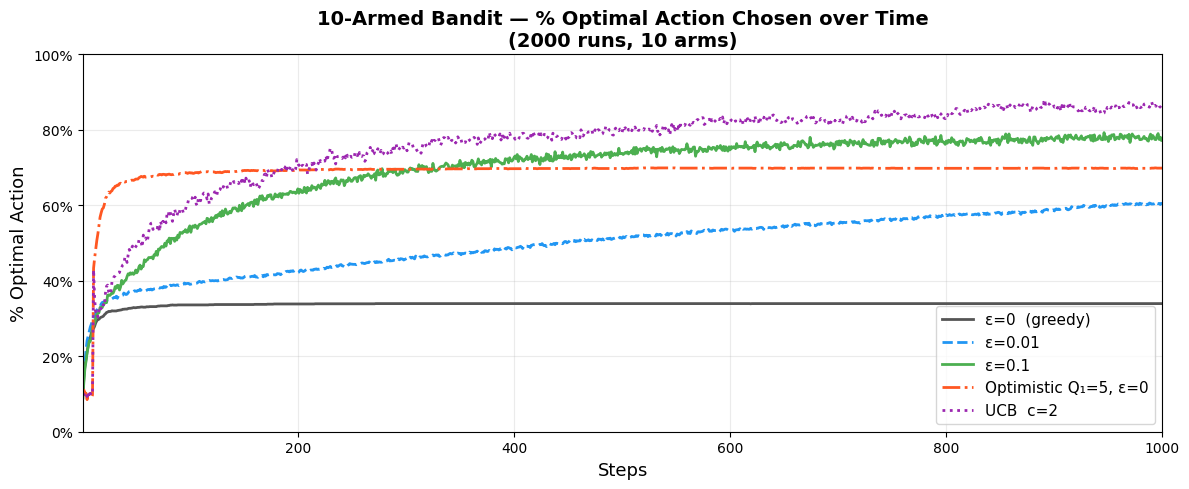

In [5]:
# Plot 2: % Optimal Action over Time

fig, ax = plt.subplots(figsize=(12, 5))

for (name, (_, pct_opt)), color, ls in zip(results.items(), colors, ls_list):
    ax.plot(steps, pct_opt, label=name, color=color, linestyle=ls, linewidth=2)

ax.set_xlabel("Steps", fontsize=13)
ax.set_ylabel("% Optimal Action", fontsize=13)
ax.set_title("10-Armed Bandit — % Optimal Action Chosen over Time\n"
             f"({RUNS} runs, {K} arms)", fontsize=14, fontweight="bold")
ax.legend(fontsize=11, loc="lower right")
ax.set_xlim(1, STEPS)
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0f}%"))
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig("pct_optimal.png", dpi=150)
plt.show()


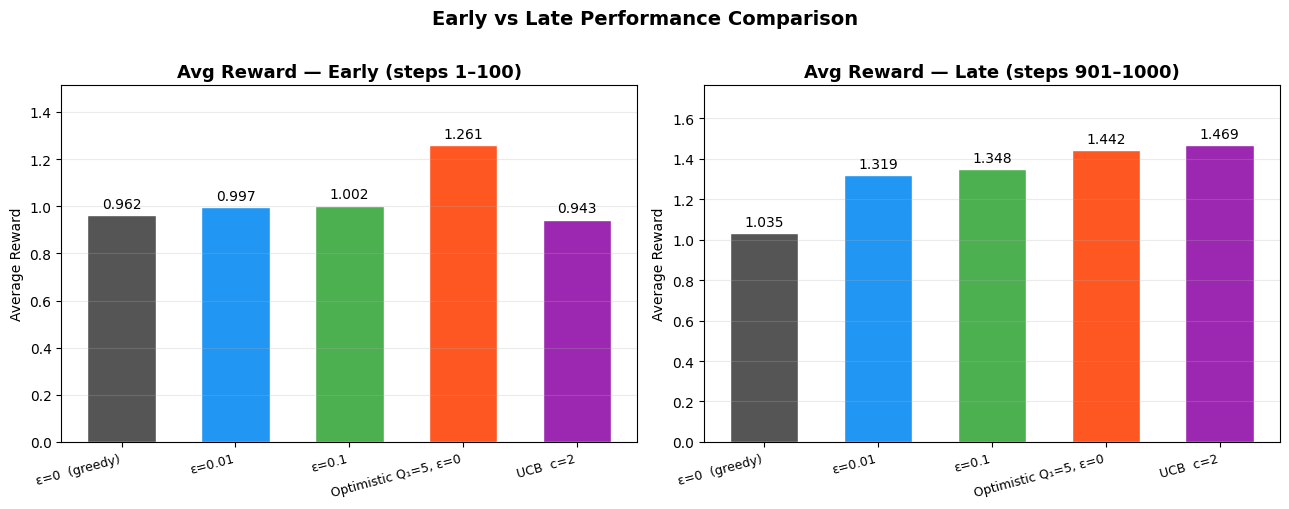

In [6]:
early = slice(0, 100)
late  = slice(900, 1000)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, sl, label in zip(axes, [early, late], ["Early (steps 1–100)", "Late (steps 901–1000)"]):
    means = [results[n][0][sl].mean() for n in strategies]
    bars  = ax.bar(list(strategies.keys()), means, color=colors, edgecolor="white", width=0.6)
    ax.bar_label(bars, fmt="%.3f", fontsize=10, padding=3)
    ax.set_title(f"Avg Reward — {label}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Average Reward")
    ax.set_ylim(0, max(means) * 1.2)
    ax.set_xticks(range(len(strategies)))
    ax.set_xticklabels(list(strategies.keys()), rotation=15, ha="right", fontsize=9)
    ax.grid(axis="y", alpha=0.25)

plt.suptitle("Early vs Late Performance Comparison", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("early_vs_late.png", dpi=150)
plt.show()

In [7]:
# Summary Table

print(f"\n{'Strategy':<25} {'Final Avg Reward':>18} {'Final % Optimal':>16}")
print("─" * 62)
for name, (avg_r, pct_opt) in results.items():
    print(f"{name:<25} {avg_r[-1]:>18.3f} {pct_opt[-1]:>15.1f}%")


Strategy                    Final Avg Reward  Final % Optimal
──────────────────────────────────────────────────────────────
ε=0  (greedy)                          1.012            34.0%
ε=0.01                                 1.310            60.5%
ε=0.1                                  1.316            77.7%
Optimistic Q₁=5, ε=0                   1.447            69.8%
UCB  c=2                               1.480            86.5%
